In [1]:
cd /orange/adamginsburg/jwst/brick/F410M/pipeline/

/orange/adamginsburg/jwst/brick/mastDownload/JWST/F410M/pipeline


In [2]:
basepath = '/orange/adamginsburg/jwst/brick'

# Massimo's destreaker below

In [3]:
from astropy.io import fits
from matplotlib import style, pyplot as plt
from astropy.visualization import simple_norm
import numpy as np
from astropy.stats import sigma_clip,SigmaClip

In [4]:
 %matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20
font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [5]:
%run $basepath/reduction/destreak.py

In [6]:
input_image = "jw02221001001_07101_00008_nrcalong_cal.fits"

fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
destreaked = im2 = destreak_data(image, median_filter_size=15)

# reload b/c destreaking is inplace
fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
image.shape

(2048, 2048)

0 1


findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.


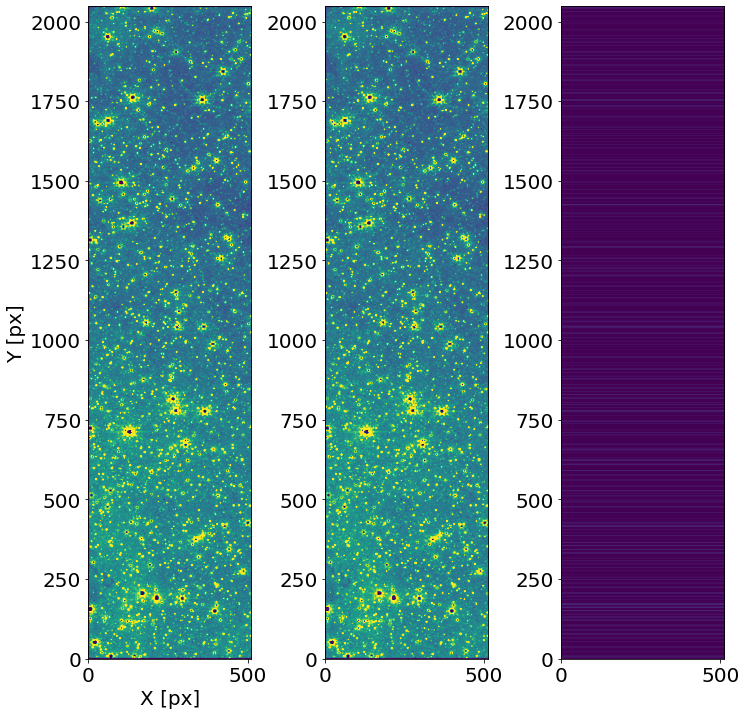

In [7]:
plt.figure(figsize=(12, 12))
#for start in range(0, 2048, 512):
start = 0
print(start, (start//512)+1)
ax = plt.subplot(1, 3, 1)
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)

norm_to_match = simple_norm(im1[:, slice(start, start+512)], 'sqrt', percent=95.)
ax.imshow(im1[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 2).imshow(destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 3).imshow(im1[:, slice(start, start+512)] - destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.show()

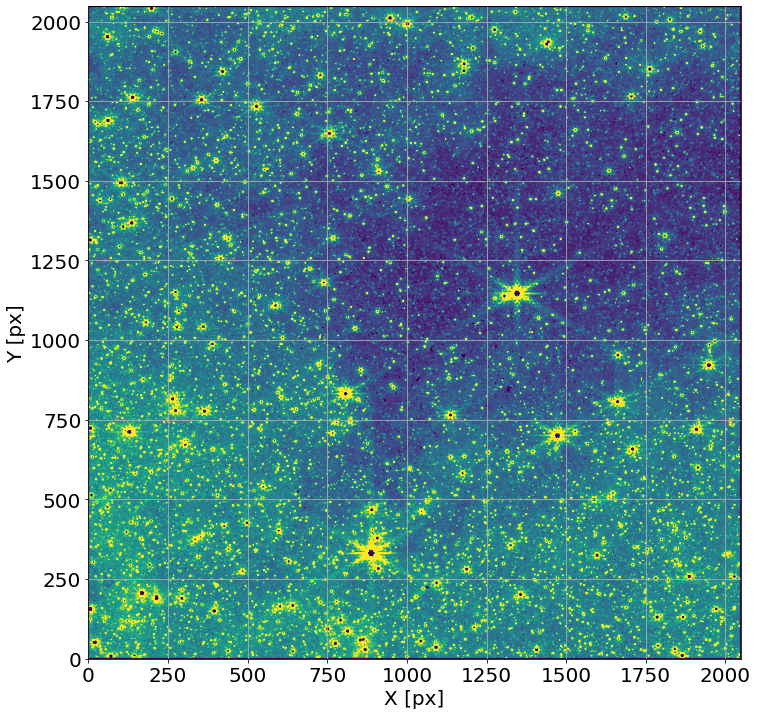

In [8]:
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(image, 'sqrt', percent=95.)
plt.imshow(image, norm=norm_to_match, cmap='viridis')
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.grid()

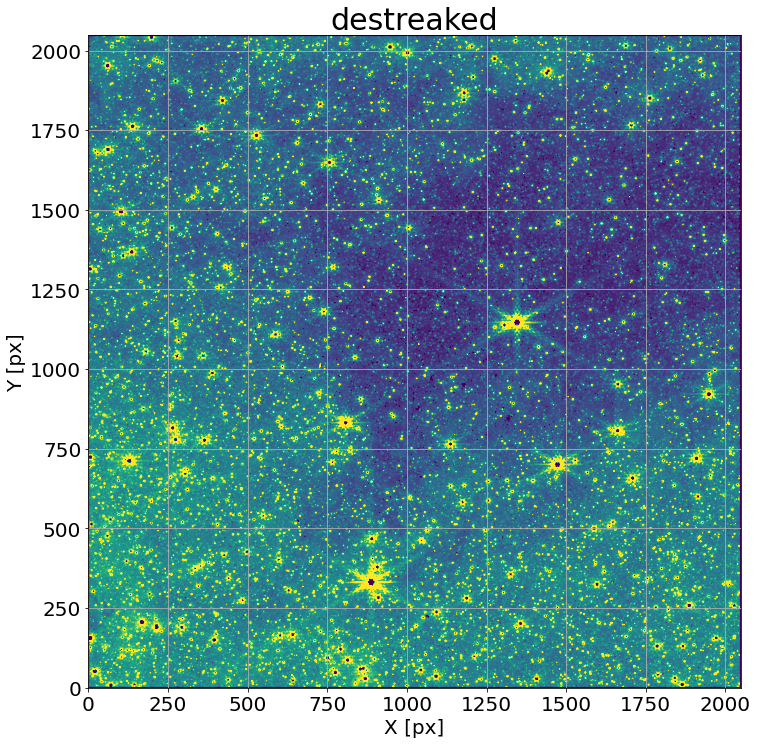

In [9]:
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(image, 'sqrt', percent=95.)
plt.imshow(destreaked, norm=norm_to_match, cmap='viridis')
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title("destreaked")
plt.grid()

In [10]:
# define horizontal quadrants
q1 = image[:,0:512]
q2 = image[:,512:1024]
q3 = image[:,1024:1536]
q4 = image[:,1536:2048]

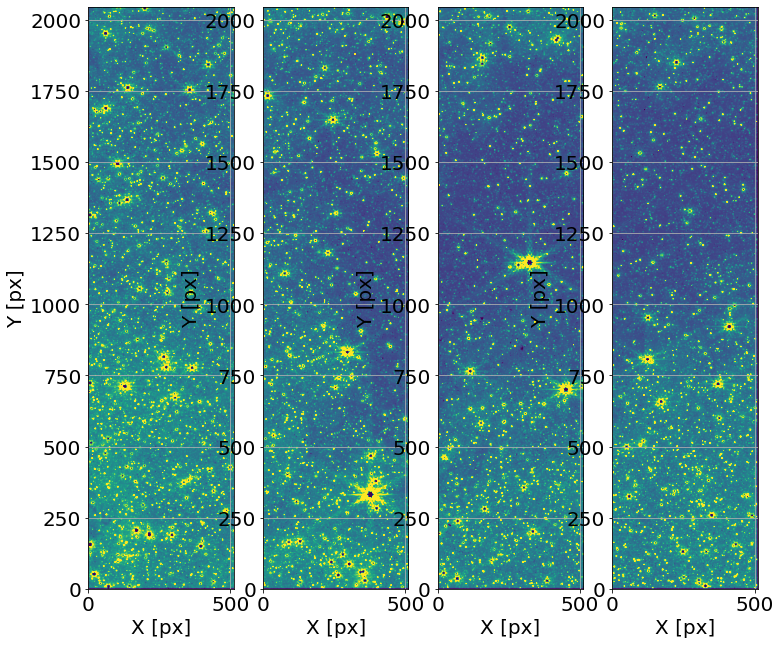

In [11]:
%matplotlib inline
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(q1, 'sqrt', percent=95.)
for ii, qq in enumerate([q1,q2,q3,q4]):
    ax = plt.subplot(1, 4, ii+1)
    plt.xlabel("X [px]", fontdict=font2)
    plt.ylabel("Y [px]", fontdict=font2)
    plt.grid()

    ax.imshow(qq, norm=norm_to_match, cmap='viridis')

In [12]:
v1 = np.percentile(q1, 1, axis=1)[:,None]
v2 = np.percentile(q2, 1, axis=1)[:,None]
v3 = np.percentile(q3, 1, axis=1)[:,None]
v4 = np.percentile(q4, 1, axis=1)[:,None]

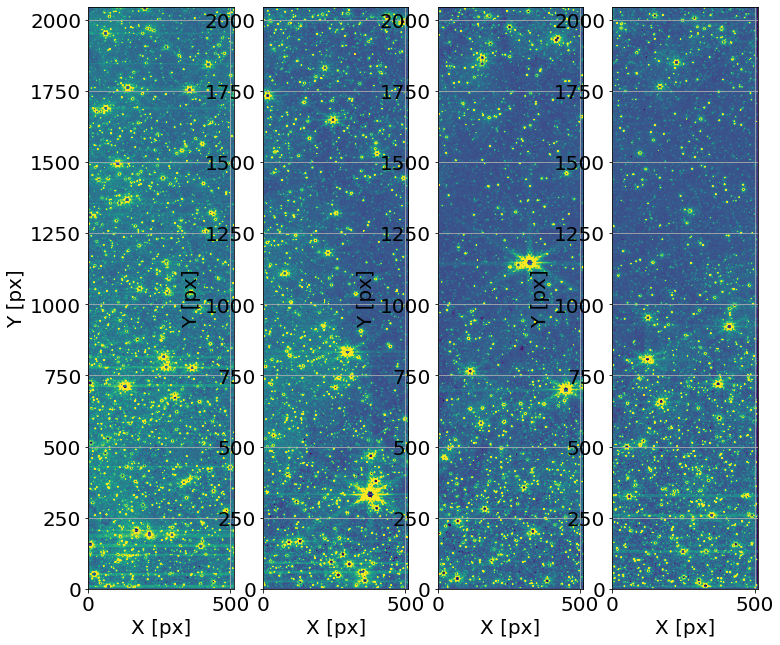

In [13]:
%matplotlib inline
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(q1, 'sqrt', percent=95.)
for ii, qq in enumerate([q1,q2,q3,q4]):
    ax = plt.subplot(1, 4, ii+1)
    plt.xlabel("X [px]", fontdict=font2)
    plt.ylabel("Y [px]", fontdict=font2)
    plt.grid()

    vv = np.percentile(qq, 5, axis=1)[:,None]
    ax.imshow(qq - vv + np.median(vv), norm=norm_to_match, cmap='viridis')

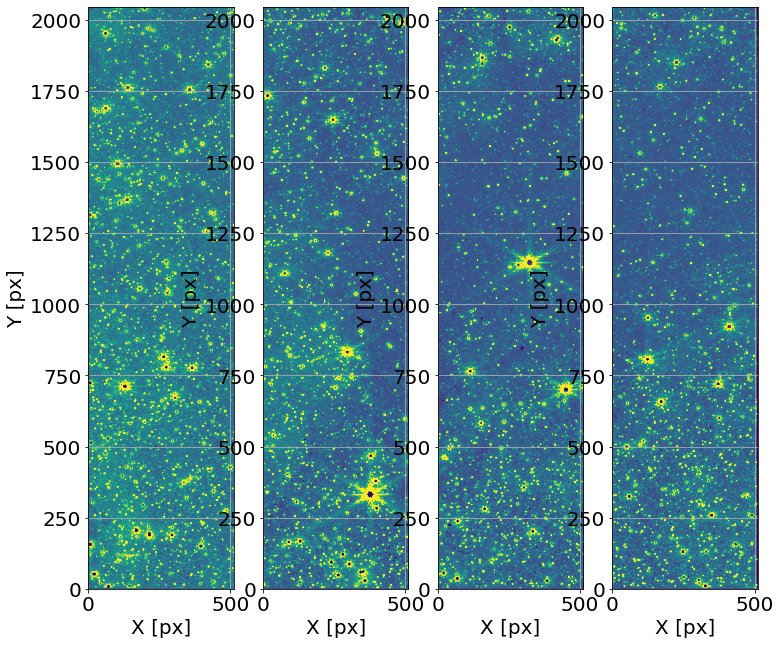

In [14]:
%matplotlib inline
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(q1, 'sqrt', percent=95.)

def nozero_percentile(arr, pct, **kwargs):
    arr = arr.copy()
    arr[arr == 0] = np.nan
    return np.nanpercentile(arr, pct, **kwargs)

for ii, qq in enumerate([q1,q2,q3,q4]):
    ax = plt.subplot(1, 4, ii+1)
    plt.xlabel("X [px]", fontdict=font2)
    plt.ylabel("Y [px]", fontdict=font2)
    plt.grid()

    vv = nozero_percentile(qq, 5, axis=1)[:,None]
    ax.imshow(qq - vv + np.median(vv), norm=norm_to_match, cmap='viridis')

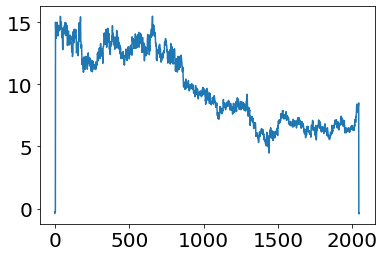

In [15]:
plt.plot(np.percentile(q1, 10, axis=1))

In [16]:

def destreak(frame, percentile=5, overwrite=True):
    assert frame.endswith('_cal.fits')
    hdu = fits.open(frame)
    data = hdu[('SCI', 1)].data

    for start in range(0, 2048, 512):
        chunk = data[:, slice(start, start+512)]
        pct = np.percentile(chunk, percentile, axis=1)
        data[:, slice(start, start+512)] = chunk - pct[:,None] + np.median(pct)
    
    hdu[('SCI', 1)].data = data
    
    hdu.writeto(frame.replace("_cal.fits", "_destreak.fits"), overwrite=overwrite)
        

In [17]:
destreak("jw02221001001_05101_00018_nrca1_cal.fits")

FileNotFoundError: [Errno 2] No such file or directory: 'jw02221001001_05101_00018_nrca1_cal.fits'

In [ ]:
im1 = fits.getdata(input_image, ext=('SCI', 1))
im2 = fits.getdata(input_image.replace("_cal.fits", "_destreak.fits"), ext=('SCI', 1))

In [ ]:
%matplotlib inline

In [ ]:
data = im2
norm_to_match = simple_norm(q1, 'sqrt', percent=95.)
plt.figure(figsize=(12, 12))
for start in range(0, 2048, 512):
    print(start, (start//512)+1)
    ax = plt.subplot(1, 4, (start//512) + 1)
    plt.xlabel("X [px]", fontdict=font2)
    plt.ylabel("Y [px]", fontdict=font2)
    plt.grid()

    ax.imshow(data[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.show()

# F405N

In [ ]:
input_image = f"{basepath}/F405N/pipeline/jw02221001001_03101_00008_nrcalong_cal.fits"

fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
destreaked = im2 = destreak_data(image, median_filter_size=256)

# reload b/c destreaking is inplace
fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
image.shape

In [ ]:
plt.figure(figsize=(12, 12))
#for start in range(0, 2048, 512):
start = 768 # BETWEEN, looking at overlap zone
print(start, (start//512)+1)
ax = plt.subplot(1, 3, 1)
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)

norm_to_match = simple_norm(im1[:, slice(start, start+512)], 'sqrt', percent=95.)
ax.imshow(im1[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 2).imshow(destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 3).imshow(im1[:, slice(start, start+512)] - destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
#for start in range(0, 2048, 512):
start = 0
print(start, (start//512)+1)
ax = plt.subplot(1, 3, 1)
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)

norm_to_match = simple_norm(im1[:, slice(start, start+512)], 'sqrt', percent=95.)
ax.imshow(im1[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 2).imshow(destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 3).imshow(im1[:, slice(start, start+512)] - destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(image, 'sqrt', percent=95.)
plt.imshow(image, norm=norm_to_match, cmap='viridis')
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.grid()

In [ ]:
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(image, 'sqrt', percent=95.)
plt.imshow(destreaked, norm=norm_to_match, cmap='viridis')
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title("destreaked")
plt.grid()

# F466N

In [ ]:
input_image = f"{basepath}/F466N/pipeline/jw02221001001_05101_00008_nrcalong_cal.fits"

fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
destreaked = im2 = destreak_data(image, median_filter_size=55)

# reload b/c destreaking is inplace
fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
image.shape

In [ ]:
plt.figure(figsize=(12, 12))
#for start in range(0, 2048, 512):
start = 0
print(start, (start//512)+1)
ax = plt.subplot(1, 3, 1)
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)

norm_to_match = simple_norm(im1[:, slice(start, start+512)], 'sqrt', percent=95.)
ax.imshow(im1[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 2).imshow(destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 3).imshow(im1[:, slice(start, start+512)] - destreaked[:, slice(start, start+512)],  cmap='viridis')
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
#for start in range(0, 2048, 512):
start = 768 #(between)
print(start, (start//512)+1)
ax = plt.subplot(1, 3, 1)
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)

norm_to_match = simple_norm(im1[:, slice(start, start+512)], 'sqrt', percent=95.)
ax.imshow(im1[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 2).imshow(destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 3).imshow(im1[:, slice(start, start+512)] - destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(image, 'sqrt', percent=95.)
plt.imshow(image, norm=norm_to_match, cmap='viridis')
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.grid()

In [ ]:
plt.figure(figsize=(12, 12))
norm_to_match = simple_norm(image, 'sqrt', percent=95.)
plt.imshow(destreaked, norm=norm_to_match, cmap='viridis')
plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title("destreaked")
plt.grid()